# Predict GDP of Canada

<hr>

## Source of data

The 
<a href='https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?locations=CA'>source</a> 
of the data used here is the World Bank national accounts data, and OECD National Accounts data files.

## GDP (current US$) - Canada

GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in current U.S. dollars. Dollar figures for GDP are converted from domestic currencies using single year official exchange rates. For a few countries where the official exchange rate does not reflect the rate effectively applied to actual foreign exchange transactions, an alternative conversion factor is used.

## What is in this notebook?

Here using machine learing techniques I have created a model to predict GDP (in US$) of Canada.

<hr>

In [1]:
# To avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('data.csv')
df.head()

,year,per capita income (US$)
0,1970,3399.299037
1,1971,3768.297935
2,1972,4251.175484
3,1973,4804.463248
4,1974,5576.514583


In [3]:
df.describe()

,year,per capita income (US$)
count,47.000000,47.000000
mean,1993.000000,18920.137063
std,13.711309,12034.679438
min,1970.000000,3399.299037
25%,1981.500000,9526.914515
50%,1993.000000,16426.725480
75%,2004.500000,27458.601420
max,2016.000000,42676.468370


<hr>

## Data Analysis

year                       0.943884
per capita income (US$)    1.000000
Name: per capita income (US$), dtype: float64


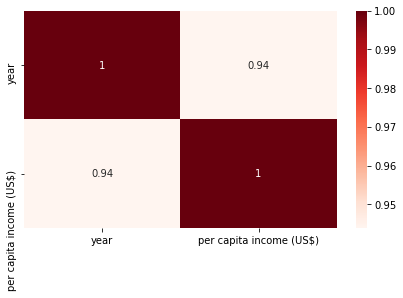

In [4]:
print(df.corr()['per capita income (US$)'].sort_values())

# Using Pearson Correlation
plt.figure(figsize=(7,4))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### There is a high correlation between 'year' and 'per capita income (US$)'

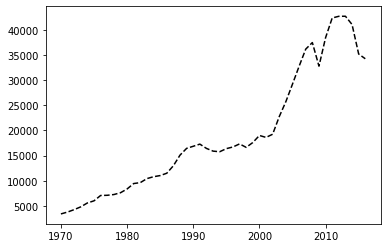

In [5]:
plt.plot(df[['year']], df[['per capita income (US$)']], color='k', linestyle='--')

<hr>

## Creating Model

#### Splitting the dataset

Since per capita income (US$) is increasing slowly in the beginning and between 2000 and 2010 it increased rapidly, so we have to suffle the dataset so that we can get increasing trend of per capita income correctly.

In [6]:
# Shuffling the dataset
df = df.sample(frac=1, random_state=3)

In [7]:
_feature = 'year'
_target = 'per capita income (US$)'

train_dataset = df[:35]
X_train = np.array(train_dataset[_feature]).reshape(-1, 1)
y_train = np.array(train_dataset[_target]).reshape(-1, 1)

test_dataset = df[36:47]
X_test = np.array(test_dataset[_feature]).reshape(-1, 1)
y_test = np.array(test_dataset[_target]).reshape(-1, 1)

#### Feature Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

#### Cross Validation

In [9]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=3)

score = cross_val_score(LinearRegression(), X_train, y_train, cv=kf, scoring='r2')
print(f'LinearRegression: {score.mean()}')

score = cross_val_score(Ridge(), X_train, y_train, cv=kf, scoring='r2')
print(f'Ridge: {score.mean()}')

LinearRegression: 0.88506418278699
Ridge: 0.8824747785785633


#### Learning Curve

In [10]:
from sklearn.model_selection import learning_curve

_size = np.arange(0.01, 1.01, 0.01)
train_sizes = np.array(_size)
scoring = 'neg_mean_squared_error'

train_sizes_abs, train_scores, cv_scores = learning_curve(LinearRegression(), X_train, y_train, train_sizes=train_sizes, cv=kf, scoring=scoring)

In [11]:
train_scores_mean = []
for row in train_scores:
    _mean = row.mean()
    train_scores_mean.append(_mean)
    
cv_scores_mean = []
for row in cv_scores:
    _mean = row.mean()
    cv_scores_mean.append(_mean)    
    
train_scores_mean = -np.array(train_scores_mean)
cv_scores_mean = -np.array(cv_scores_mean)

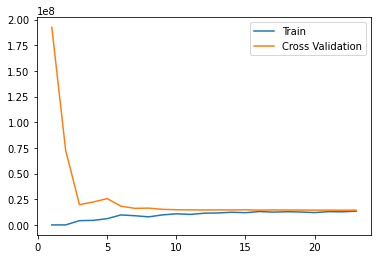

In [12]:
plt.plot(train_sizes_abs, train_scores_mean, label='Train')
plt.plot(train_sizes_abs, cv_scores_mean, label='Cross Validation')

plt.legend()

#### Fitting the model

In [13]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Optimal Parameters

In [14]:
coefficient = model.coef_
intercept = model.intercept_

print("Coefficient: ", coefficient)
print("Intercept: ", model.intercept_)

Coefficient:  [[10890.83513738]]
Intercept:  [18918.974524]


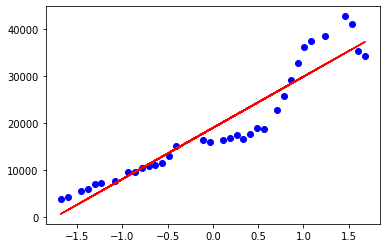

In [15]:
plt.scatter(X_train, y_train,  color='blue')
plt.plot(X_train, coefficient*X_train + intercept, '-r')

#### Predicting

In [16]:
y_test_pred = model.predict(X_test)
y_test_pred

array([[26576.30558925],
       [33284.94077031],
       [31794.1329523 ],
       [10177.4195911 ],
       [16886.05477216],
       [18376.86259018],
       [ 2723.38050104],
       [ 8686.61177309],
       [ 4959.59222806],
       [20613.0743172 ],
       [34030.34467932]])

In [17]:
y_test

array([[19232.17556 ],
       [42334.71121 ],
       [32755.17682 ],
       [ 8355.96812 ],
       [16426.72548 ],
       [17266.09769 ],
       [ 3399.299037],
       [ 7247.967035],
       [ 4804.463248],
       [15755.82027 ],
       [42665.25597 ]])

#### Evaluating Model

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
# *** Out-Of-Sample Forecast ***

# To see how our model performs on data that model has NOT seen

rms_error = mean_squared_error(y_test, y_test_pred, squared=False)
r2_score_value = r2_score(y_test, y_test_pred)

print(f"Root mean squared error: {rms_error}")
print(f"R2-score: {r2_score_value}")

Root mean squared error: 4692.604463545105
R2-score: 0.879497092141861


#### Pipeline

In [20]:
from sklearn.pipeline import Pipeline

In [21]:
scaling = ('scale', StandardScaler())
model = ('model', LinearRegression())

# Steps in the pipeline
steps = [scaling, model]

pipe = Pipeline(steps=steps)

# Fiitting the model
model = pipe.fit(X_train, y_train)

# Out-Of-Sample Forecast
y_test_pred = model.predict(X_test)

# Evaluation
rms_error = mean_squared_error(y_test, y_test_pred, squared=False)
r2_score_value = r2_score(y_test, y_test_pred)

print(f"Root mean squared error: {rms_error}")
print(f"R2-score: {r2_score_value}")

Root mean squared error: 4692.604463545105
R2-score: 0.879497092141861


#### Saving the model

In [22]:
from joblib import dump, load

dump(model, 'model.joblib') 

['model.joblib']

#### Visualizing our prediction against actual values

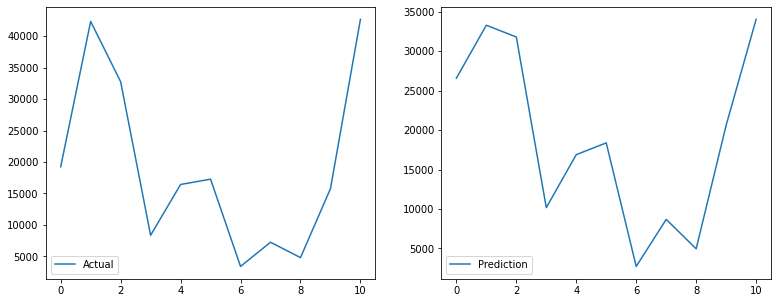

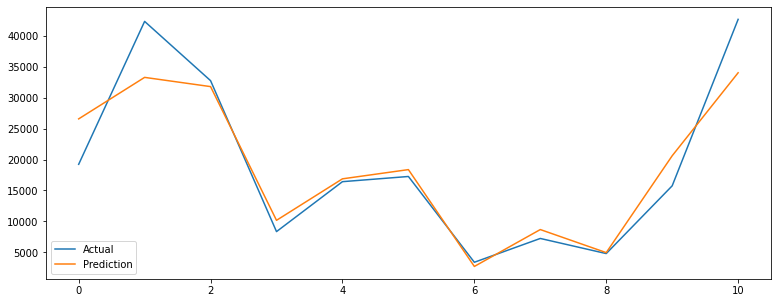

In [23]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

ax1.plot(np.arange(len(y_test)), y_test, label='Actual')
ax2.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax1.legend()
ax2.legend()

f, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))

ax3.plot(np.arange(len(y_test)), y_test, label='Actual')
ax3.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax3.legend()

<hr>